# Demand forecasting with the transformer

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths
os.chdir("../")  # start working from the project root path

In [2]:
from scipy import interpolate

In [14]:
import datetime

In [3]:
import copy
from pathlib import Path
import warnings
import pickle

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from models import TemporalFusionTransformer
from data import GroupNormalizer, TimeSeriesDataSet
from metrics import SMAPE, PoissonLoss, QuantileLoss
from models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## Load data

In [84]:
data = pd.read_csv("data/pep.csv")

# get rid of spaces in column names for better compatibility for pandas version
data.rename(columns={"Delivery plant":"Delivery_plant"}, inplace=True)
data.rename(columns={"SDV Price":"SDV_Price"}, inplace=True)
data.rename(columns={"Brand Group":"Brand_Group"}, inplace=True)
data.rename(columns={"Sub Brand":"Sub_Brand"}, inplace=True)
data["Date"] = data['Date'].astype('datetime64')

In [85]:
all_sku = data['zsku'].value_counts().to_frame().transpose().columns
all_plant = data['Delivery_plant'].value_counts().to_frame().transpose().columns

In [86]:
data.columns

Index(['zsku', 'Date', 'Delivery_plant', 'Ton', 'SDV_Price', 'Category',
       'Brand_Group', 'Brand', 'Sub_Brand', 'Flavor', 'Size'],
      dtype='object')

## Merge data

In different zsku and deplivery plant, there are often multiple records generated on the same day, which may be returns or multiple sales. Because the predicted granularity is accurate to daily, so the daily data is merged.

It is worth noting that the negative ton will be discarded directly, because the purpose of this task is to guide production. Negative value represents a return. Even if a return occurs in the process of selling the product, the requirements for production remain unchanged. Because first of all, the returned products cannot be directly used for resale. Secondly, even if possible, in the process of arranging the production of new products, if the return is taken into account, this is a very unreasonable and inaccurate production arrangement.

Another thing to notice is that some int value will be converted to float format because the merge operations (sum, mean).

In [7]:
# TODO: rewrite as function
def merge_dateframe(dataframe, criterion, sum_merge='Ton', mean_merge="SDV_Price"):
    pass

### Merge daily data

In [8]:
group_daily_criterion = ['zsku', 'Delivery_plant', 'Date', 'Category', 'Brand_Group', 'Brand', 'Sub_Brand', 'Flavor', 'Size']

# Discard negative ton
data.drop(data.index[(data['Ton'] < 0)], inplace=True)

In [9]:
# Merge daily data
dup_rows = data[data.duplicated(subset=group_daily_criterion, keep=False)]
data.drop(dup_rows.index,axis=0,inplace=True)

merge_ton=dup_rows.groupby(group_daily_criterion)['Ton'].sum()
merge_price=dup_rows.groupby(group_daily_criterion)['SDV_Price'].mean()
merge_rows = pd.merge(merge_ton, merge_price, right_index=True, left_index=True)
merge_rows.reset_index(level=group_daily_criterion, inplace=True)
data.sort_values(by=group_daily_criterion, inplace=True, ascending=True, ignore_index=True)

### Merge weekly data

In [10]:
# Merge weekly data
group_weekly_criterion = ['zsku', 'Delivery_plant', 'Category', 'Brand_Group', 'Brand', 'Sub_Brand', 'Flavor', 'Size', 'Time_idx']

# Add time index
data["Time_idx"] = (data["Date"].dt.year - 2020) * 52 + data["Date"].dt.week   
data.drop("Date", axis=1, inplace=True)

dup_rows = data[data.duplicated(subset=group_weekly_criterion, keep=False)]
data.drop(dup_rows.index,axis=0,inplace=True)

merge_ton=dup_rows.groupby(group_weekly_criterion)['Ton'].sum()
merge_price=dup_rows.groupby(group_weekly_criterion)['SDV_Price'].mean()
merge_rows = pd.merge(merge_ton, merge_price, right_index=True, left_index=True)
merge_rows.reset_index(level=group_weekly_criterion, inplace=True)
data.sort_values(by=group_weekly_criterion, inplace=True, ascending=True, ignore_index=True)

## Filter data with too few data points and do data interpolation

In [11]:
# Filter data that has too few data points
available_sku = []
available_sku_points = {}
unavailable_sku = []
all_sku = data['zsku'].value_counts().to_frame().transpose().columns
for sku in all_sku:
    df_filter = data[data["zsku"] == sku]
    if df_filter["Time_idx"].max() - df_filter["Time_idx"].min() > 15:  # to ensure train plus test is over 15 weeks
        available_sku_points[sku] = len(df_filter)    
        if len(df_filter) > 29:
            available_sku.append(sku)
        else:
            unavailable_sku.append(sku)
    else:
        unavailable_sku.append(sku)
        
for usku in unavailable_sku:
    data.drop(data[data["zsku"] == usku].index, inplace=True)

In [39]:
def convert_timeidx(line):
    line['year'] = 2020 + int(line["Time_idx"] / 52)
    line['week_in_year'] = line["Time_idx"] % 52
    return line

In [43]:
data = data.apply(convert_timeidx, axis=1)

In [44]:
# Convet back to int values after merge operations
data["zsku"] = data['zsku'].astype('int')
data["Delivery_plant"] = data['Delivery_plant'].astype('int')
data["Category"] = data['Category'].astype('int')
data["Brand_Group"] = data['Brand_Group'].astype('int')
data["Brand"] = data['Brand'].astype('int')
data["Sub_Brand"] = data['Sub_Brand'].astype('int')
data["Flavor"] = data['Flavor'].astype('int')
data["Size"] = data['Size'].astype('int')
data["Time_idx"] = data['Time_idx'].astype('int')
data["year"] = data['year'].astype('int')
data["week_in_year"] = data['week_in_year'].astype('int')

# data.to_csv("data/pep_processed.csv", index=False)
# f = interpolate.CubicSpline(data_81.index.values.astype('d'), data_81["Ton"])
# temp_y=f(pd.date_range(start=data_81.index.values[0], end=data_81.index.values[-1]).values.astype('d'))

## Start building model

In [87]:
data = pd.read_csv("data/pep_processed.csv")

data["zsku"] = data['zsku'].astype(str).astype('category')
data["Delivery_plant"] = data['Delivery_plant'].astype(str).astype('category')
data["Category"] = data['Category'].astype(str).astype('category')
data["Brand_Group"] = data['Brand_Group'].astype(str).astype('category')
data["Sub_Brand"] = data['Sub_Brand'].astype(str).astype('category')
data["Brand"] = data['Brand'].astype(str).astype('category')
# data["year"] = data['year'].astype(str).astype('category')

In [90]:
data

,zsku,Delivery_plant,Ton,SDV_Price,Category,Brand_Group,Brand,Sub_Brand,Flavor,Size,Time_idx,year,week_in_year
0,45,0,180.00,181.00,1,5,4,26,74,1500,18,2020,18
1,45,0,540.00,181.00,1,5,4,26,74,1500,19,2020,19
2,45,0,45.00,181.00,1,5,4,26,74,1500,21,2020,21
3,45,0,180.00,181.00,1,5,4,26,74,1500,22,2020,22
4,45,0,270.00,181.00,1,5,4,26,74,1500,24,2020,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,352,0,42.00,55.25,3,3,3,12,20,70,132,2022,28
402,352,0,72.24,55.25,3,3,3,12,20,70,136,2022,32
403,352,0,0.84,55.25,3,3,3,12,20,70,139,2022,35
404,352,0,15.12,55.25,3,3,3,12,20,70,140,2022,36


### Create dataset and dataloaders

In [96]:
max_prediction_length = 9
max_encoder_length = 24
# training_cutoff = data["time_idx"].max() - max_prediction_length
training_cutoff = 120

training = TimeSeriesDataSet(
    data[lambda x: x.Time_idx <= training_cutoff],
    time_idx="Time_idx",
    target="Ton",
    group_ids=["Delivery_plant", "zsku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['Delivery_plant', 'zsku', 'Category', 'Brand_Group', 'Brand', 'Sub_Brand'],
    static_reals=['Flavor', 'Size'],
    time_varying_known_reals=["year", "SDV_Price", "Time_idx", "week_in_year"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Ton",
    ],
    target_normalizer=GroupNormalizer(
        groups=["Delivery_plant", "zsku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

### Train

In [92]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    # limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/Users/erick.keyu.qi/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 24.7k


In [93]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 116   
3  | prescalers                         | ModuleDict                      | 176   
4  | static_variable_selection          | VariableSelectionNetwork        | 4.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.0 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Hyperparameter tuning

In [ ]:
import pickle

from models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

In [122]:
# show best hyperparameters
print(study.best_trial.params)

{'gradient_clip_val': 0.6141871886683972, 'hidden_size': 68, 'dropout': 0.18248873689309514, 'hidden_continuous_size': 25, 'attention_head_size': 2, 'learning_rate': 0.08390851847845274}


## Evaluate performance

PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.

In [98]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [106]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
((actuals - predictions)/actuals).abs().mean()

tensor(0.9047)

In [107]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

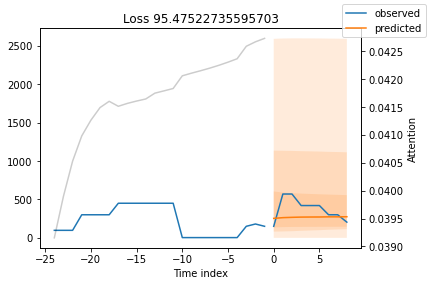

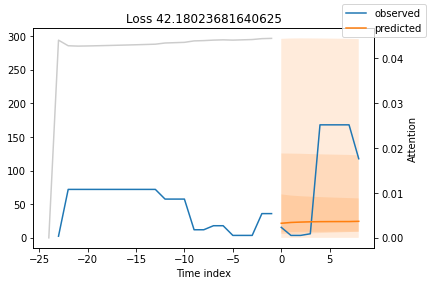

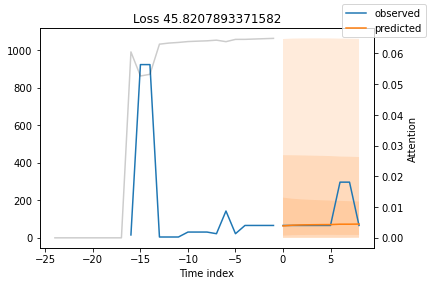

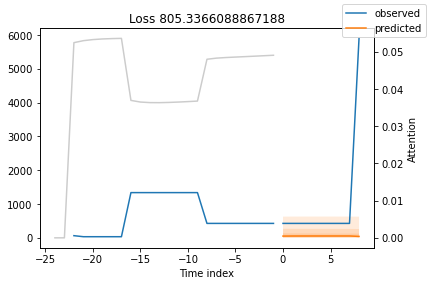

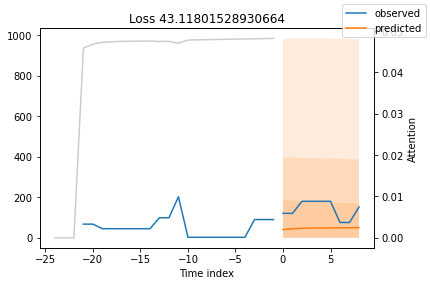

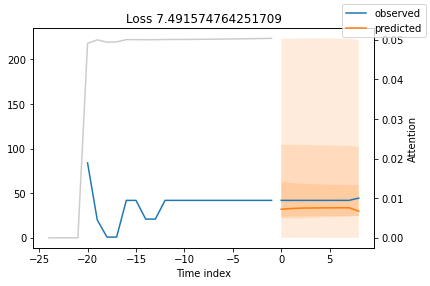

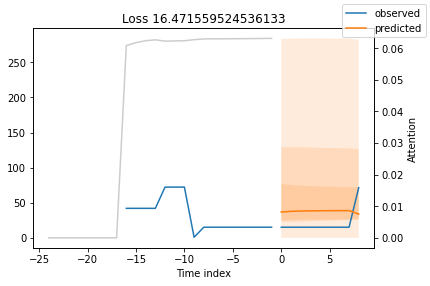

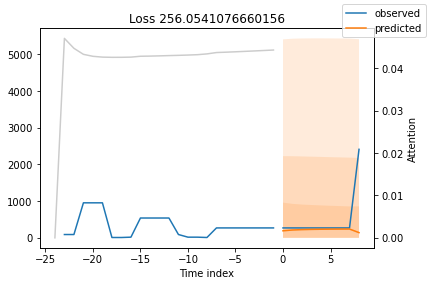

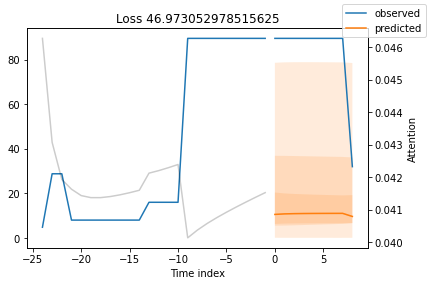

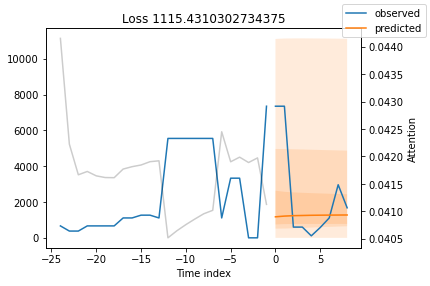

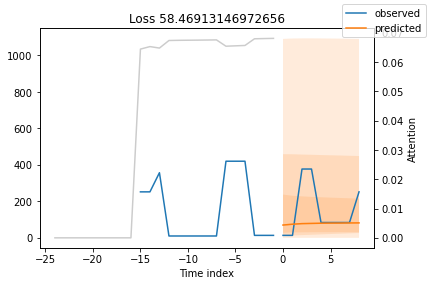

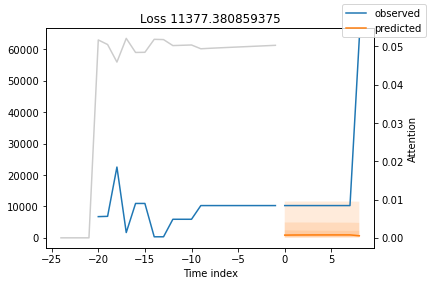

In [126]:
for idx in range(12):  # plot all 12 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

### Worst performers

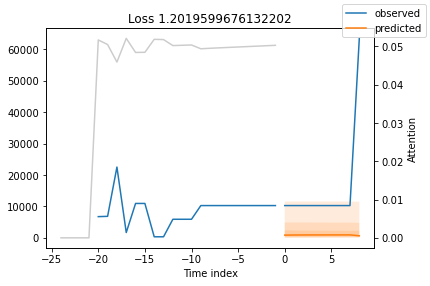

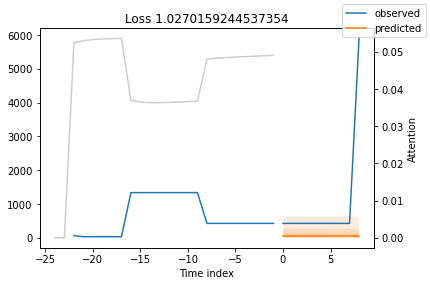

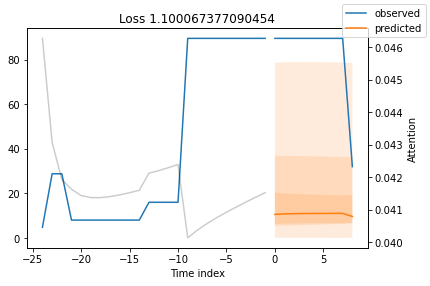

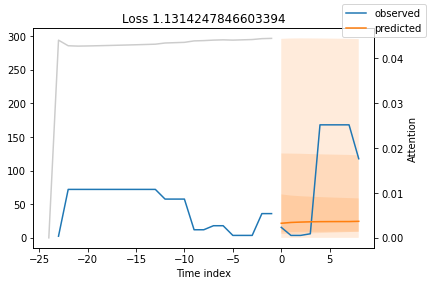

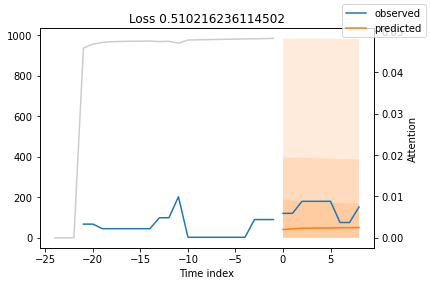

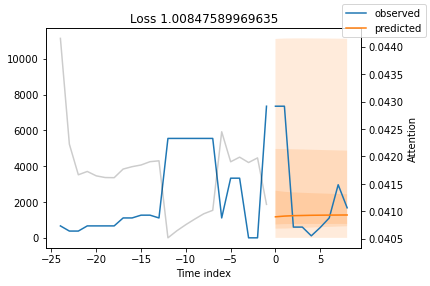

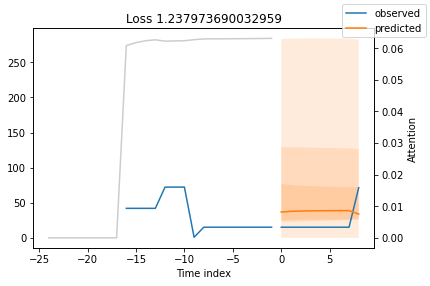

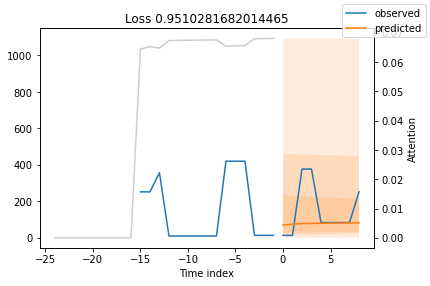

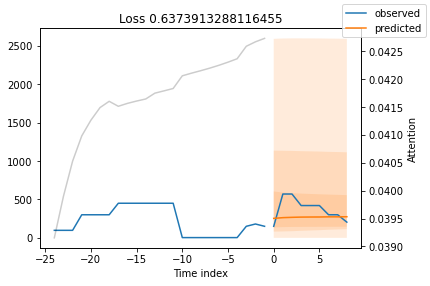

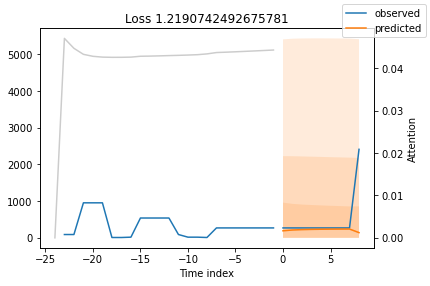

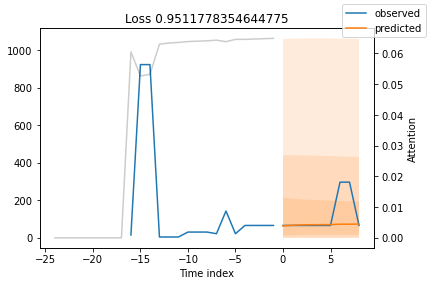

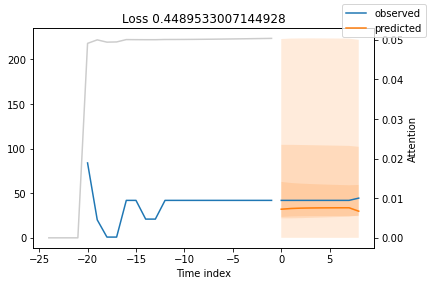

In [127]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(12):  # plot 12 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

### Actuals vs predictions by variables

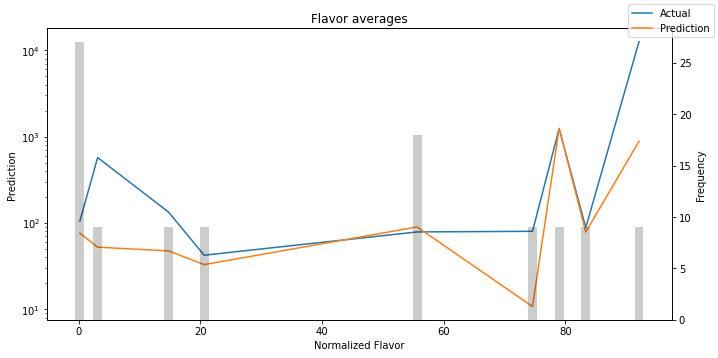

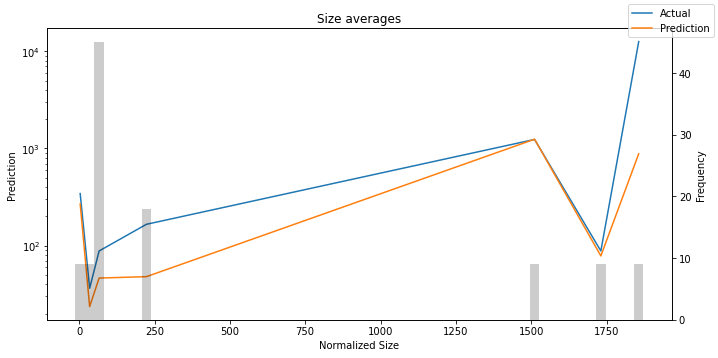

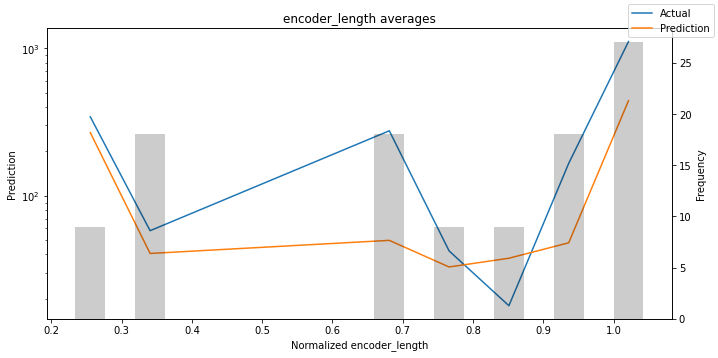

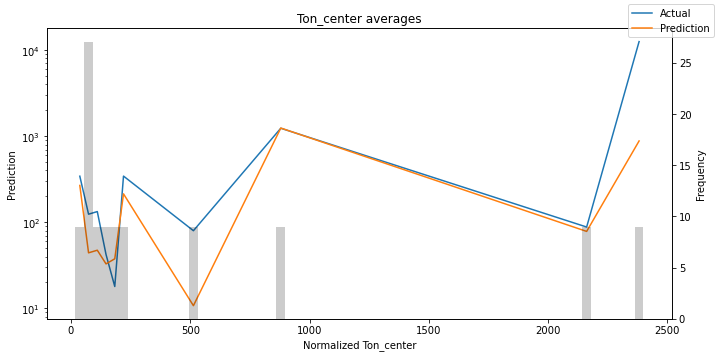

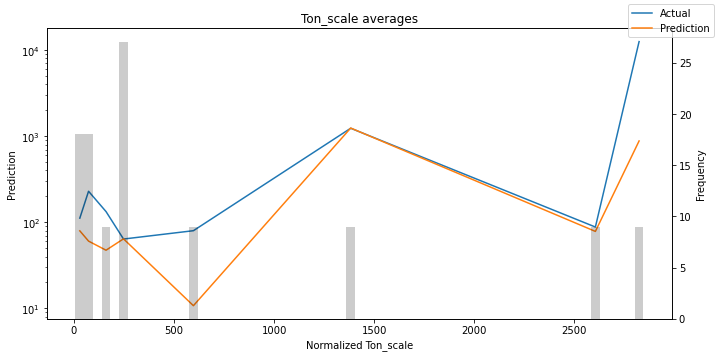

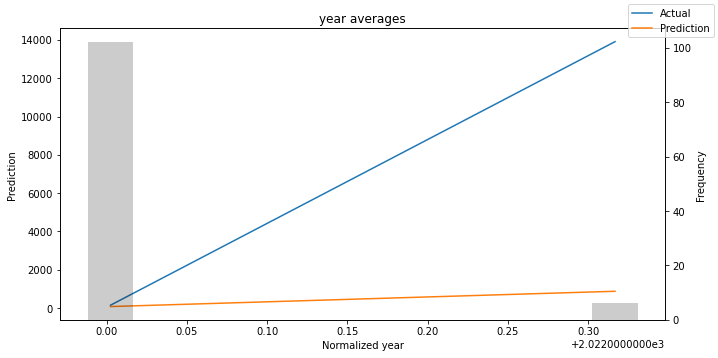

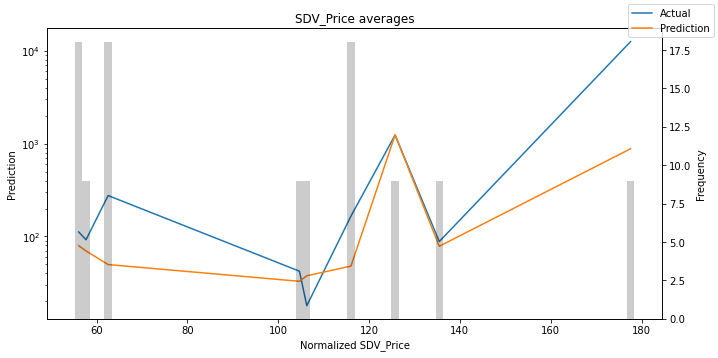

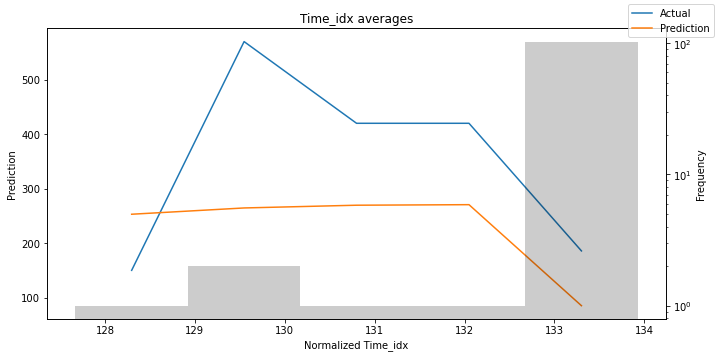

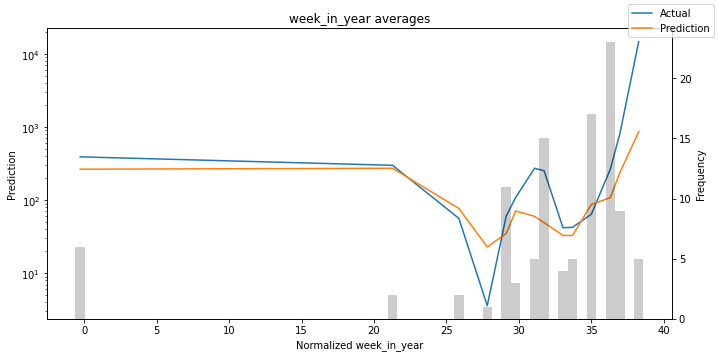

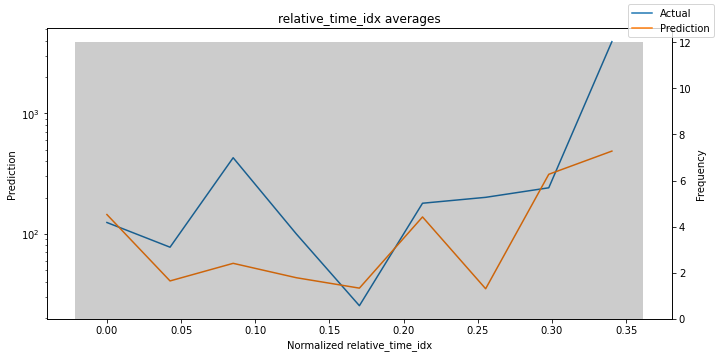

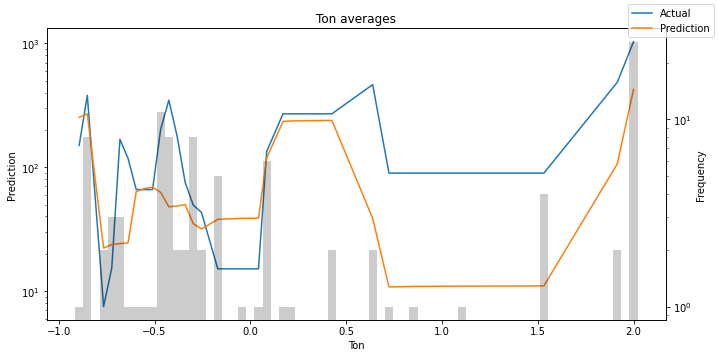

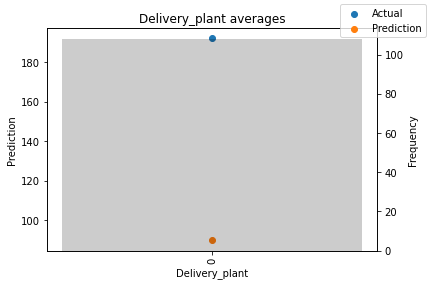

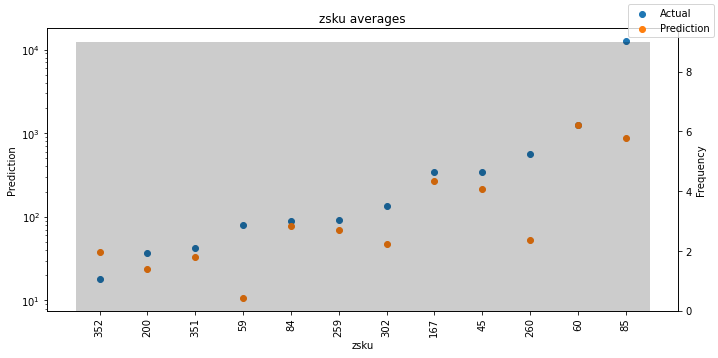

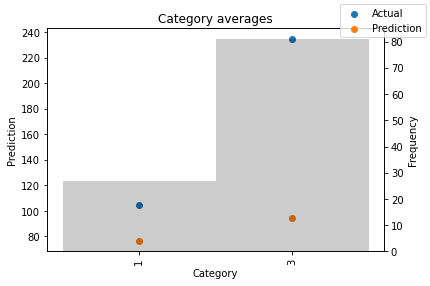

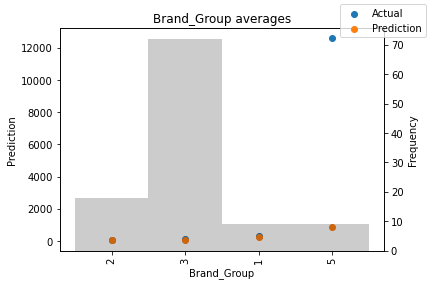

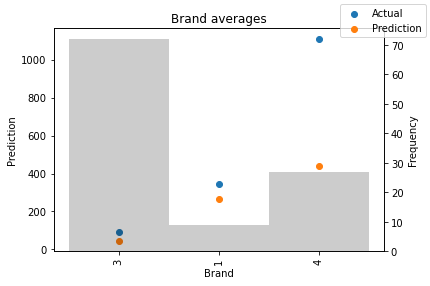

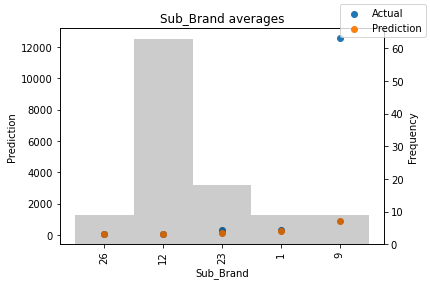

In [109]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Interpret model

### Variable importances

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x342 with 1 Axes>,
 'encoder_variables': <Figure size 504x252 with 1 Axes>,
 'decoder_variables': <Figure size 504x234 with 1 Axes>}

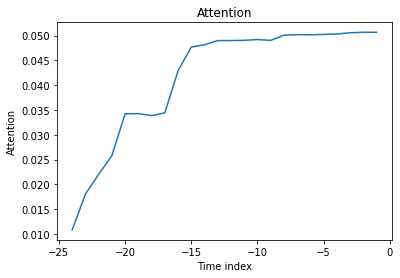

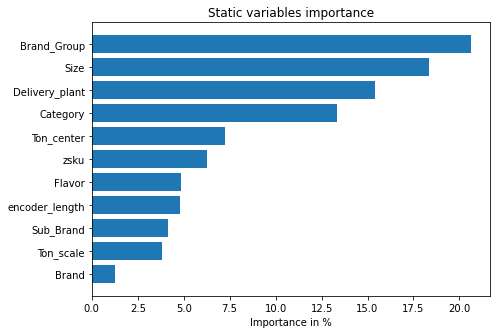

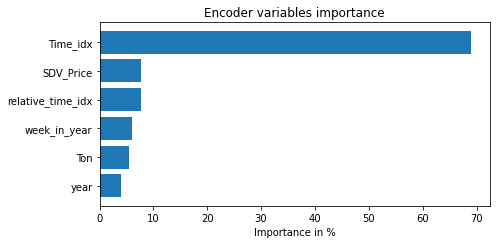

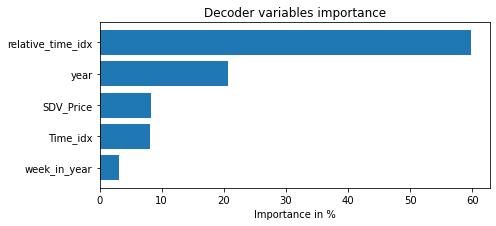

In [118]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

### Partial dependency

In [120]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "SDV_Price", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

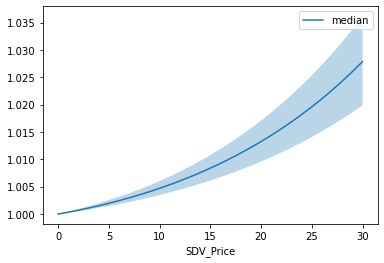

In [121]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("SDV_Price").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);